# Gait

- Kevin Walchko
- 30 April 2018

---

cc

---

![](quad-4-links.png)

blah ...

# Definitions

- blah

## Setup

In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import numpy as np
from math import cos, sin, pi, atan2, sqrt, acos
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib import rc
from IPython.display import HTML

In [2]:
from quadruped import DiscreteRippleGait
from quadruped import Leg4

In [3]:
# when i call the animation, this will make it work
# rc('animation', html='html5')

# Walking

![](ax-12-quad-servos.png)

The gait is designed for a 4 legged robot. Each leg is identical with 4 joints: coxa, femur, tibia, and tarsus. These joints are common to spiders. The kinematics are designed to follow the [modified DH process](https://en.wikipedia.org/wiki/Denavit%E2%80%93Hartenberg_parameters#Modified_DH_parameters).

In [4]:
# using gait, lets create the leg angles
# gait: cmd -> feet position for each step
# leg: feet pos -> servo angles for each step
# rplot -> plots each of those servo angles

def walk(cmd):
    data = {
        # [ length, (limits), offset]
        'coxa':   [52, [-90, 90], 150],
        'femur':  [90, [-100, 100], 150],   # fixme
        'tibia':  [89, [-190, 120], 220],  # fixme
        'tarsus': [90, [-90, 90], 150],

        # gait
        # Angles: 0.00 75.60 -120.39 -45.22
        # 0.00 93.51 -138.68 -44.83
        'stand': [0, 94, -139, -45],  # this determines the neutral leg position
        # 'sit': [0, 90, -90, -90],

        # engine
        # 'serialPort': '/dev/tty.usbserial-A506BOT5'
    }

    leg = Leg4(data)  # 4 servo leg
    gait = DiscreteRippleGait(35.0, leg.getNeutralPos())  # ripple gait
    # cmd = [1,0,0]                             # go straight
    # cmd = [0,0,pi/2]                             # turn
    pts = gait.oneCycle_alt(*cmd)              # array of 3d foot pts
    # print(pts)
    angle = leg.generateServoAngles_alt(pts)  # array of leg servo angles
    # print(angle)
    return pts, angle

## Straight

First let's calculate the robot's foot position and servo angles. Each leg is identical, so we will only generate the movement for 1 leg and then do a rotation/translation to re-orient the desired foot placement for the remaining 3 legs.

Looking at the diagram above, when the robot is moving "straight" in the body frame, it is actually moving in a diagonal as observed in the leg frame. Thus, when calculating foot positions for each step, we expect to see that diagonal movement.

In [5]:
pts, angle = walk([1,0,0])

DH2Servo[1] error 117 > 100
DH2Servo[1] error 113 > 100
DH2Servo[1] error 101 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 101 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 117 > 100
DH2Servo[1] error 113 > 100
DH2Servo[1] error 106 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 101 > 100
DH2Servo[1] error 105 > 100
DH2Servo[1] error 108 > 100
DH2Servo[1] error 105 > 100
DH2Servo[1] error 108 > 100
DH2Servo[1] error 106 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 101 > 100


Let's first plot the feet positions in the body frame and see if we are moving straight.

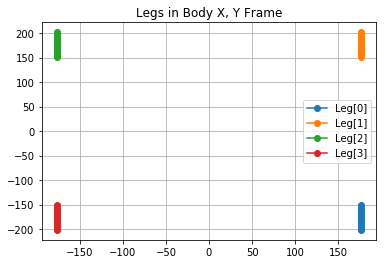

In [6]:
def plot_body_frame(pts):
    def rot_z(t, c):
        """
        t - theta [radians]
        c - [x,y,z]
        return - [x,y,z] numpy array rotated about z-axis
        """
        ans = [
            c[0]*cos(t)-c[1]*sin(t),
            c[0]*sin(t)+c[1]*cos(t),
            c[2]
        ]

        return ans

    # plot things in global body frame
    body = [(100,-100), (100,100),(-100,100),(-100,-100)] # CCW
    frame = [-pi/4, pi/4, 3*pi/4, -3*pi/4]
    for ll in range(4):
        aa = frame[ll]
        pp = [rot_z(aa, p) for p in pts[ll]]
        xx = [v[0]+body[ll][0] for v in pp]
        yy = [v[1]+body[ll][1] for v in pp]
        plt.title('Legs in Body X, Y Frame'.format(ll))
        plt.plot(xx,yy, label='Leg[{}]'.format(ll), marker='o')
        plt.grid(True)
    plt.legend();
    
plot_body_frame(pts)

### Sequence

The robot lifts its legs in an ordered sequence. Looking at the state diagram and the graph below, the order is 0, 3, 1, 2. **fix image**

![](quad-sequence.png)

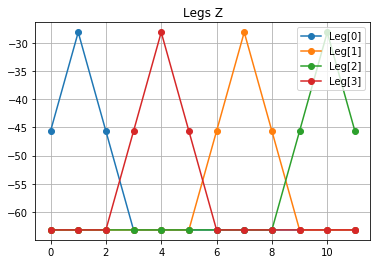

In [7]:
# order of lift is: 0, 3, 1, 2, repeat
for ll in range(4):
    ww = [sqrt(v[0]**2 + v[1]**2) for v in pts[ll]]
    zz = [v[2] for v in pts[ll]]
    plt.title('Legs Z'.format(ll))
    plt.plot(zz, label='Leg[{}]'.format(ll), marker='o')
    plt.grid(True)
plt.legend();

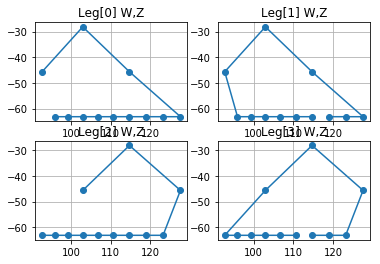

In [8]:
def plot_feet(pts):
    for ll in range(4):
        ww = [sqrt(v[0]**2 + v[1]**2) for v in pts[ll]]
        zz = [v[2] for v in pts[ll]]
        plt.subplot(2,2,ll+1)
        plt.plot(ww,zz, marker='o')
        plt.title('Leg[{}] W,Z'.format(ll))
        plt.grid()
        
plot_feet(pts)

In [9]:
# plt.plot(angle[0])
# plt.ylabel('Angle [deg]')
# plt.xlabel('Step')
# plt.grid();

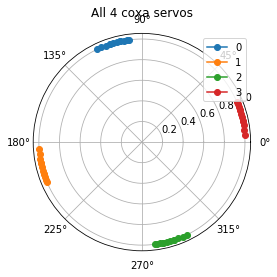

In [10]:
def plot_coxa(angle):
    frame = [-pi/4, pi/4, 3*pi/4, -3*pi/4]
    ax = plt.subplot(111, projection='polar')
    for ll in range(4):
        tt = [(v[0]*pi/180)+frame[ll] for v in angle[ll]]
        rr = [1]*len(tt)
        ax.plot(tt, rr, label=str(ll), marker='o')
    ax.legend()
    ax.set_title('All 4 coxa servos');

plot_coxa(angle)

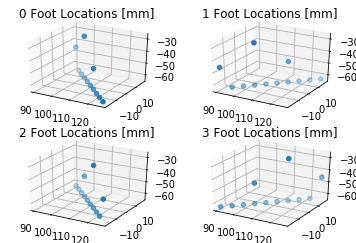

In [26]:
def plot_feet_3d(pts):
    fig = plt.figure()
    for ll in range(4):
        ax = fig.add_subplot(2,2,ll+1, projection='3d')
        xx = [v[0] for v in pts[ll]]
        yy = [v[1] for v in pts[ll]]
        zz = [v[2] for v in pts[ll]]
        ax.scatter(xx,yy,zz)
        ax.set_title('{} Foot Locations [mm]'.format(ll));

plot_feet_3d(pts)

In [49]:
class LegVis(object):
    def __init__(self, angle, legNum=0):
        # when i call the animation, this will make it work
        rc('animation', html='html5')

        # for some stupid reason, matplotlib/jupyter plots the thing twice
        # this shuts it off until we are ready to turn back on inline plotting
        %matplotlib agg
        %matplotlib agg
        
        self.angle = angle
        self.legNum = legNum

        fig = plt.figure()
        self.fig = fig
        
        # radial plot 
        self.ax1 = fig.add_subplot(121,projection='polar')
        self.ax1.set_title('Azimuth Angle (x-y plane)\n')
        # line1, = ax1.plot([], [], lw=2)
        self.line1 = Line2D([], [], color='black')
        self.ax1.add_line(self.line1)
        # ax1.set_aspect('equal', 'datalim')

        # scatter plot
        self.ax2 = fig.add_subplot(122, aspect='equal')
        # line2, = ax2.plot([], [], lw=2)
        self.line2 = Line2D([], [], color='black', linewidth=2)
        self.ax2.set_xlabel('w')
        self.ax2.set_ylabel('z')
        self.ax2.add_line(self.line2)
        self.ax2.set_xlim(-10, 300)
        self.ax2.set_ylim(-100, 150)
        # ax2.set_aspect('equal')
        self.ax2.grid()  # turn grid on
        self.ax2.set_title('Leg {}'.format(self.legNum))
        
    def rplot(self, t1, t2, t3, t4, degrees=True):
        """Given the 4 joint angles (in rads), plot the arm in the x-y and w-z planes

        x = (d2 + l1*cos(t2) + l2*cos(t2 + t3) + l3*cos(t2 + t3 + t4))*cos(t1)
        y = (d2 + l1*cos(t2) + l2*cos(t2 + t3) + l3*cos(t2 + t3 + t4))*sin(t1)
        z = l1*sin(t2) + l2*sin(t2 + t3) + l3*sin(t2 + t3 + t4)
        """
        l1 = 52
        l2 = 89
        l3 = 90
        l4 = 95

        ptsx = [0]
        ptsy = [0]

        if degrees:
            t1 *= pi/180
            t2 *= pi/180
            t3 *= pi/180
            t4 *= pi/180


        # our definition is reverse or these joints
        # link 1
        x0 = l1
        y0 = 0
        ptsx.append(x0)
        ptsy.append(y0)

        # link 2
        x1 = x0 + l2*cos(t2)
        y1 = y0 + l2*sin(t2)
        ptsx.append(x1)
        ptsy.append(y1)

        # link 3
        x2 = x1 + l3*cos(t2 + t3)
        y2 = y1 + l3*sin(t2 + t3)
        ptsx.append(x2)
        ptsy.append(y2)

        # link 4
        x3 = x2 + l4*cos(t2 + t3 + t4)
        y3 = y2 + l4*sin(t2 + t3 + t4)
        ptsx.append(x3)
        ptsy.append(y3)

        self.line1.set_data([0, t1], [0, 1.0])
        self.line2.set_data(ptsx, ptsy)
        return (self.line1, self.line2)
    
    def anim_animate(self, i):
        angles = self.angle[self.legNum][i]
        # put back into DH space, note, the offsets aren't all the same
        aa = [a-o for a,o in zip(angles, [150,150,220,150])]
        return self.rplot(*aa)
    
    def run(self):
        %matplotlib inline
        return animation.FuncAnimation(self.fig, self.anim_animate, frames=len(self.angle[self.legNum]), blit=True)

In [50]:
# rc('animation', html='html5')
s = LegVis(angle)
anim = s.run()
anim
# HTML(anim.to_html5_video())
# anim.save('mymovie.mp4')

# Turn

In [36]:
pts, angle = walk([0,0,pi/2])

DH2Servo[1] error 104 > 100
DH2Servo[1] error 109 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 109 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 109 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 109 > 100
DH2Servo[1] error 104 > 100


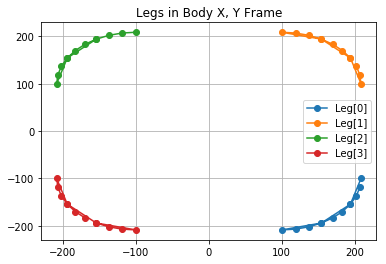

In [37]:
plot_body_frame(pts)

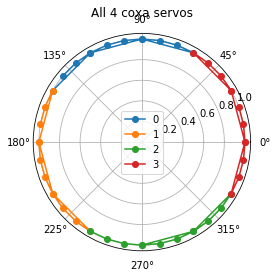

In [38]:
plot_coxa(angle)

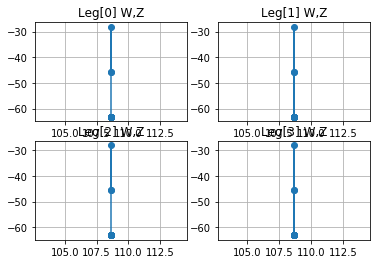

In [39]:
plot_feet(pts)

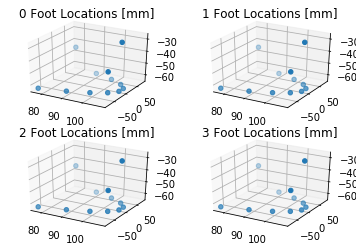

In [40]:
plot_feet_3d(pts)

In [41]:
s = LegVis(angle)
anim = s.run()
anim

# Diagonal

Now this time we are walking at a diagonal. Notice because of the diagonal direction, 2 of the legs coxa servos do not move, they only the move (kind of like reach) in the W-Z frame.

In [51]:
pts, angle = walk([1,1,0])

DH2Servo[1] error 137 > 100
DH2Servo[1] error 118 > 100
DH2Servo[1] error 103 > 100
DH2Servo[1] error 110 > 100
DH2Servo[1] error 118 > 100
DH2Servo[1] error 108 > 100
DH2Servo[1] error 103 > 100
DH2Servo[1] error 129 > 100
DH2Servo[1] error 118 > 100
DH2Servo[1] error 110 > 100
DH2Servo[1] error 103 > 100
DH2Servo[1] error 101 > 100
DH2Servo[1] error 113 > 100
DH2Servo[1] error 108 > 100
DH2Servo[1] error 103 > 100


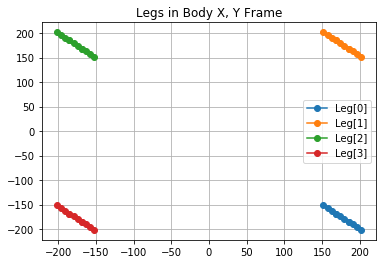

In [52]:
plot_body_frame(pts)

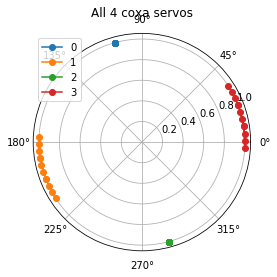

In [53]:
plot_coxa(angle)

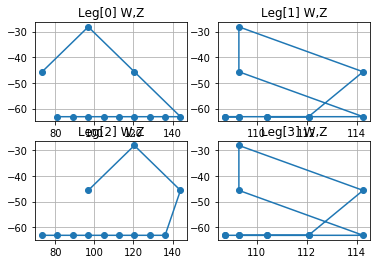

In [54]:
plot_feet(pts)

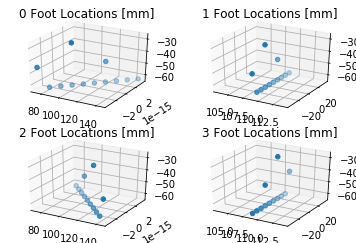

In [55]:
plot_feet_3d(pts)

In [56]:
# leg 0 is in the direction of travel and doesn't swing (see coxa angles above)
s0 = LegVis(angle,0)
anim = s0.run()
anim

In [57]:
s1 = LegVis(angle, 1)
anim = s1.run()
anim

# Stability

![](stable.png)

When walking, this gate has 3 feet down at all times and one foot moving forward. This creates a tripod that supports the body weight. This is generally considered a stable gait because of this, but if the robot is perfectly ballanced, the center of mass (CM) lies right on the inside edge of the tripod. When it comes to balancing, you need to keep your CM inside the triangle formed by the feet. Now, the reality is the robot is not perfectly balance so this is actually an issue which could cause the robot to fall over.

## Shifting CM



| Foot      | 0 | 1 | 2 | 3 | Shift |
|-----------|---|---|---|---|-------|
| 0         |   | x | x | x | 2     |
| 0         | x |   | x | x | 3     |